In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
image_size = (48, 48)

train=tf.keras.utils.image_dataset_from_directory("train", batch_size=32, image_size=image_size,seed=10)
test=tf.keras.utils.image_dataset_from_directory("test", batch_size=32, image_size=image_size,seed=10)

class_names=train.class_names

print(class_names)

Found 24278 files belonging to 5 classes.
Found 5998 files belonging to 5 classes.
['angry', 'fearful', 'happy', 'sad', 'surprised']


In [ ]:
train_dataset = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.8 and logs.get('accuracy')>0.8):
      print("\nvalidation accuracy is > 80%!")
      self.model.stop_training = True

callback = Callback()

In [ ]:
def identity_block(x, filter):
    x_skip = x

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def convolutional_block(x, filter):

    x_skip = x

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)

    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet34(shape = (32, 32, 3), classes = 10):

    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    block_layers = [3, 4, 6, 3]
    filter_size = 64

    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)

    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [ ]:
X_SIZE = image_size[0]
Y_SIZE = image_size[1]
NUM_OF_CLASSES = len(class_names)

callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model = ResNet34(shape=(X_SIZE, Y_SIZE, 3), classes = NUM_OF_CLASSES)

model.compile( loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [ ]:
history = model.fit(train_dataset,batch_size = 10, epochs=100, validation_data=valid_dataset, callbacks=[callback, callback2])

Epoch 1/100
759/759 [==============================] - 29s 34ms/step - loss: 1.8211 - accuracy: 0.2512 - val_loss: 10.7777 - val_accuracy: 0.2609
Epoch 2/100
759/759 [==============================] - 25s 33ms/step - loss: 1.5125 - accuracy: 0.3489 - val_loss: 1.8289 - val_accuracy: 0.3786
Epoch 3/100
759/759 [==============================] - 25s 33ms/step - loss: 1.3778 - accuracy: 0.4114 - val_loss: 1.3892 - val_accuracy: 0.3875
Epoch 4/100
759/759 [==============================] - 25s 34ms/step - loss: 1.2857 - accuracy: 0.4511 - val_loss: 1.4662 - val_accuracy: 0.3433
Epoch 5/100
759/759 [==============================] - 25s 33ms/step - loss: 1.2210 - accuracy: 0.4744 - val_loss: 1.2485 - val_accuracy: 0.4753
Epoch 6/100
759/759 [==============================] - 25s 33ms/step - loss: 1.1742 - accuracy: 0.4964 - val_loss: 1.6356 - val_accuracy: 0.3366
Epoch 7/100
759/759 [==============================] - 25s 33ms/step - loss: 1.1228 - accuracy: 0.5145 - val_loss: 1.1776 - val_a

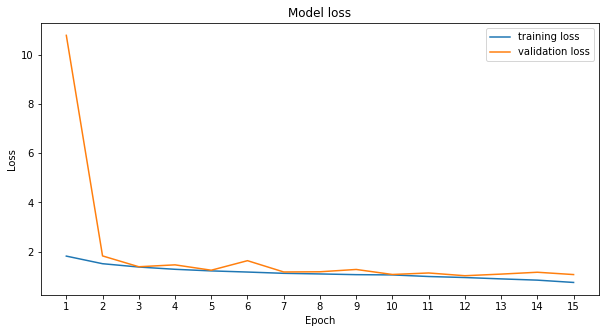

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['accuracy'])), np.arange(1, len(history.history['accuracy'])+1))
plt.legend()
plt.show()

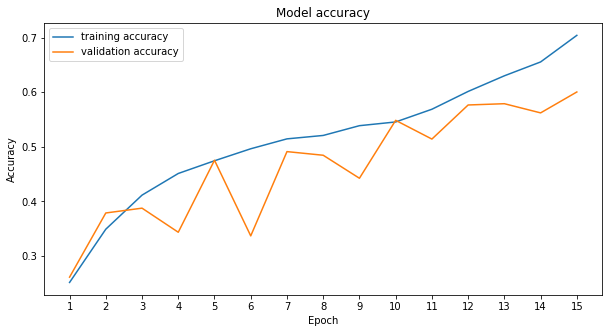

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label = "training accuracy")
plt.plot(history.history['val_accuracy'], label = "validation accuracy")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['accuracy'])), np.arange(1, len(history.history['accuracy'])+1))
plt.legend()
plt.show()